# Vega Lite Examples in Haskell - Layered Plots

The overview notebook - `VegaLiteGallery` - describes how 
[`hvega`](http://hackage.haskell.org/package/hvega)
is used to create Vega-Lite visualizations.

-----

## Table of Contents

This notebook represents the [Layered Plots](https://vega.github.io/vega-lite/examples/#layered-plots)
section of the [Vega-Lite example gallery](https://vega.github.io/vega-lite/examples/).

Those labelled `(repeat)` are shown in the "Single View Plots" notebook.
I'm having a hard-enough-time getting links to examples within the same notebook
to work, so I'm afraid I haven't tried to get cross-notebook linking working.

### [1. Labelling and Annotation](#Labelling-and-Annotation)

 - Simple Bar Chart with Labels (repeat)
 - Layering text over heatmap (repeat)
 - Carbon Dioxide in the Atmosphere (repeat)
 - [Bar Chart Highlighting Values beyond a Threshold](#Bar-Chart-Highlighting-Values-beyond-a-Threshold)
 - [Mean overlay over precipitation chart](#Mean-overlay-over-precipitation-chart)
 - [Histogram with a Global Mean Overlay](#Histogram-with-a-Global-Mean-Overlay)
 - [Line Chart with Highlighted Rectangles](#Line-Chart-with-Highlighted-Rectangles)
 - [Layering Averages over Raw Values](#Layering-Averages-over-Raw-Values)
 - [Layering Rolling Averages over Raw Values](#Layering-Rolling-Averages-over-Raw-Values)
 - [Distributions and Medians of Likert Scale Ratings](#Distributions-and-Medians-of-Likert-Scale-Ratings)
 - [Comparative Likert Scale Ratings](#Comparative-Likert-Scale-Ratings)
 - Bar with Label Overlays (repeat)

### [2. Other Layered Plots](#Other-Layered-Plots)

 - [Candlestick Chart](#Candlestick-Chart)
 - [Ranged Dot Plot](#Ranged-Dot-Plot)
 - [Bullet Chart](#Bullet-Chart)
 - [Layered Plot with Dual-Axis](#Layered-PLot-with-Dual-Axis)
 - Horizon Graph (repeat)
 - [Weekly Weather Plot](#Weekly-Weather-Plot)
 - [Wheat and Wages Example](#Wheat-and-Wages-Example)

---

## Versions

The notebook was last run with the following versions of [`hvega`](https://hackage.haskell.org/package/hvega) and
related modules:

In [1]:
:!ghc-pkg latest ghc
:!ghc-pkg latest ihaskell
:!ghc-pkg latest hvega
:!ghc-pkg latest ihaskell-hvega

ghc-8.4.4

ihaskell-0.10.0.2

hvega-0.7.0.0

ihaskell-hvega-0.2.4.0

As to when it was last run, how about:

In [2]:
import Data.Time (getCurrentTime)
getCurrentTime

2020-03-16 13:33:51.967461677 UTC

## Set up

See the overview notebook for an explanation of this section (it provides code I use to compate the `hvega` output
to the specification given in the Vega-Lite gallery).

In [3]:
:ext OverloadedStrings
:ext QuasiQuotes

In [4]:
-- VegaLite uses these names
import Prelude hiding (filter, lookup, repeat)

import Graphics.Vega.VegaLite

-- IHaskell automatically imports this if the `ihaskell-vega` module is installed
-- import IHaskell.Display.Hvega

-- If you are viewing this in an IHaskell notebook rather than Jupyter Lab,
-- use the following to see the visualizations
--
-- vlShow = id

In [5]:
import qualified Data.ByteString.Lazy.Char8 as BL8
import qualified Data.HashMap.Strict as HM
import qualified Data.Set as S

import Data.Aeson (Value(Object), encode)
import Data.Aeson.QQ.Simple (aesonQQ)
import Control.Monad (forM_, unless, when)
import Data.Maybe (fromJust)
import System.Directory (removeFile)
import System.Process (readProcess, readProcessWithExitCode)

validate ::
  VLSpec       -- ^ The expected specification
  -> VegaLite  -- ^ The actual visualization
  -> IO ()
validate exp vl = 
  let got = fromVL vl
      put = putStrLn
  in if got == exp
      then put "Okay"
      else do
        let red = "\x1b[31m"
            def = "\x1b[0m"
            
            report m = put (red ++ m ++ def)
            
        report "The visualization and expected specification do not match."
        
        -- assume both objects
        let Object oexp = exp
            Object ogot = got
            kexp = S.fromList (HM.keys oexp)
            kgot = S.fromList (HM.keys ogot)
            kmiss = S.toList (S.difference kexp kgot)
            kextra = S.toList (S.difference kgot kexp)
            keys = S.toList (S.intersection kexp kgot)
            
        unless (null kmiss && null kextra) $ do
          put ""
          report "Keys are different:"
          unless (null kmiss)  $ put ("  Missing: " ++ show kmiss)
          unless (null kextra) $ put ("  Extra  : " ++ show kextra)

        -- this often creates an impressive amount of text for what is
        -- only a small change, which is why it is followed by a call
        -- to debug
        --
        forM_ keys $ \key ->
          let vexp = fromJust (HM.lookup key oexp)
              vgot = fromJust (HM.lookup key ogot)
          in when (vexp /= vgot) $ do
            put ""
            report ("Values are different for " ++ show key)
            put ("  Expected: " ++ show vexp)
            put ("  Found   : " ++ show vgot)
          
        putStrLn ""
        report "The field-level differences are:"
        debug_ exp vl


-- Rather than come up with a way to diff JSON here, rely on `jq` and the trusty
-- `diff` command. This is not written to be robust!
--
debug_ spec vl = do
  let tostr = BL8.unpack . encode
  
  expected <- readProcess "jq" [] (tostr spec)
  got <- readProcess "jq" [] (tostr (fromVL vl))

  let f1 = "expected.json"
      f2 = "got.json"
      
  writeFile f1 expected
  writeFile f2 got
  
  let diffOpts = ["--minimal", f1, f2]
  (_, diff, _) <- readProcessWithExitCode "diff" diffOpts ""
  putStrLn diff
  
  forM_ [f1, f2] removeFile

The following is used in at least one example:

In [6]:
import qualified Data.Text as T

import qualified Data.Aeson as A
import Data.Aeson ((.=))

---

## Labelling and Annotation

 - Simple Bar Chart with Labels (repeat)
 - Layering text over heatmap (repeat)
 - Carbon Dioxide in the Atmosphere (repeat)
 - [Bar Chart Highlighting Values beyond a Threshold](#Bar-Chart-Highlighting-Values-beyond-a-Threshold)
 - [Mean overlay over precipitation chart](#Mean-overlay-over-precipitation-chart)
 - [Histogram with a Global Mean Overlay](#Histogram-with-a-Global-Mean-Overlay)
 - [Line Chart with Highlighted Rectangles](#Line-Chart-with-Highlighted-Rectangles)
 - [Layering Averages over Raw Values](#Layering-Averages-over-Raw-Values)
 - [Layering Rolling Averages over Raw Values](#Layering-Rolling-Averages-over-Raw-Values)
 - [Distributions and Medians of Likert Scale Ratings](#Distributions-and-Medians-of-Likert-Scale-Ratings)
 - [Comparative Likert Scale Ratings](#Comparative-Likert-Scale-Ratings)
 - Bar with Label Overlays (repeat)
 
---

### Bar Chart Highlighting Values beyond a Threshold

From https://vega.github.io/vega-lite/examples/layer_bar_annotations.html

In [7]:
layerBarAnnotationsSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "description": "The PM2.5 value of Beijing observed 15 days, highlighting the days when PM2.5 level is hazardous to human health. Data source https://chartaccent.github.io/chartaccent.html",
    "layer": [{
      "data": {
        "values": [
          {"Day": 1, "Value": 54.8},
          {"Day": 2, "Value": 112.1},
          {"Day": 3, "Value": 63.6},
          {"Day": 4, "Value": 37.6},
          {"Day": 5, "Value": 79.7},
          {"Day": 6, "Value": 137.9},
          {"Day": 7, "Value": 120.1},
          {"Day": 8, "Value": 103.3},
          {"Day": 9, "Value": 394.8},
          {"Day": 10, "Value": 199.5},
          {"Day": 11, "Value": 72.3},
          {"Day": 12, "Value": 51.1},
          {"Day": 13, "Value": 112.0},
          {"Day": 14, "Value": 174.5},
          {"Day": 15, "Value": 130.5}
        ]
      },
      "layer": [{
        "mark": "bar",
        "encoding": {
          "x": {"field": "Day", "type": "ordinal", "axis": {"labelAngle": 0}},
          "y": {"field": "Value", "type": "quantitative"}
        }
      }, {
        "mark": "bar",
        "transform": [
          {"filter": "datum.Value >= 300"},
          {"calculate": "300", "as": "baseline"}
        ],
        "encoding": {
          "x": {"field": "Day", "type": "ordinal"},
          "y": {"field": "baseline", "type": "quantitative"},
          "y2": {"field": "Value"},
          "color": {"value": "#e45755"}
        }
      }
    ]}, {
      "data": {
         "values": [
          {"ThresholdValue": 300, "Threshold": "hazardous"}
        ]
      },
      "layer": [{
        "mark": "rule",
        "encoding": {
          "y": {"field": "ThresholdValue", "type": "quantitative"}
        }
      }, {
        "mark": {
          "type": "text",
          "align": "right",
          "baseline": "bottom",
          "dx": -2,
          "dy": -2
        },
        "encoding": {
          "x": {
            "value": "width"
          },
          "y": {
            "field": "ThresholdValue",
            "type": "quantitative",
            "axis": {"title": "PM2.5 Value"}
          },
          "text": {"field": "Threshold", "type": "ordinal"}
        }
      }]
    }
  ]
}
|]

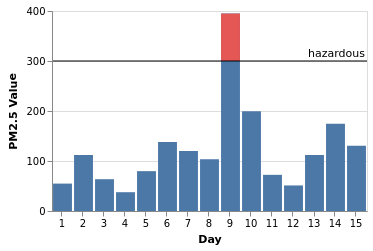

In [8]:
layerBarAnnotations =
    let label = description "The PM2.5 value of Beijing observed 15 days, highlighting the days when PM2.5 level is hazardous to human health. Data source https://chartaccent.github.io/chartaccent.html"

        days = map fromIntegral [1::Int .. 15]
        values = [54.8, 112.1, 63.6, 37.6, 79.7, 137.9, 120.1, 103.3, 394.8, 199.5, 72.3, 51.1, 112.0, 174.5, 130.5]
        dvals = dataFromColumns []
                  . dataColumn "Day" (Numbers days)
                  . dataColumn "Value" (Numbers values)

        threshold = dataFromRows [] (dataRow [("ThresholdValue", Number 300), ("Threshold", Str "hazardous")] [])
 
        posX extra = position X ([PName "Day", PmType Ordinal] ++ extra)
        
        encBar = encoding
                   . posX [PAxis [AxLabelAngle 0]]
                   . position Y [PName "Value", PmType Quantitative]
        encLine = encoding
                    . posX []
                    . position Y [PName "baseline", PmType Quantitative]
                    . position Y2 [PName "Value"]
                    . color [MString "#e45755"]
        
        transLine = transform
                       . filter (FExpr "datum.Value >= 300")
                       . calculateAs "300" "baseline"
                    
        specBar = asSpec [mark Bar [], encBar []]
        specLine = asSpec [mark Bar [], transLine [], encLine []]
        lyrBar = asSpec [dvals [], layer [specBar, specLine]]

        encRule = encoding . position Y [PName "ThresholdValue", PmType Quantitative]
        encText = encoding
                    . position X [PWidth]
                    . position Y [PName "ThresholdValue", PmType Quantitative, PAxis [AxTitle "PM2.5 Value"]]
                    . text [TName "Threshold", TmType Ordinal]
                  
        textOpts = [MAlign AlignRight, MBaseline AlignBottom, MdX (-2), MdY (-2)]
        specRule = asSpec [mark Rule [], encRule []]
        specText = asSpec [mark Text textOpts, encText []]
        lyrThresh = asSpec [threshold, layer [specRule, specText]]

        layers = layer [lyrBar, lyrThresh]

    in toVegaLite [label, layers]

vlShow layerBarAnnotations

In [9]:
validate layerBarAnnotationsSpec layerBarAnnotations

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Mean overlay over precipitation chart

From https://vega.github.io/vega-lite/examples/layer_precipitation_mean.html

In [10]:
layerPrecipitationMeanSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "data": {"url": "data/seattle-weather.csv"},
  "layer": [
    {
      "mark": "bar",
      "encoding": {
        "x": {
          "timeUnit": "month",
          "field": "date",
          "type": "ordinal"

        },
        "y": {
          "aggregate": "mean",
          "field": "precipitation",
          "type": "quantitative"
        }
      }
    },
    {
      "mark": "rule",
      "encoding": {
        "y": {
          "aggregate": "mean",
          "field": "precipitation",
          "type": "quantitative"
        },
        "color": {"value": "red"},
        "size": {"value": 3}
      }
    }
  ]
}
|]

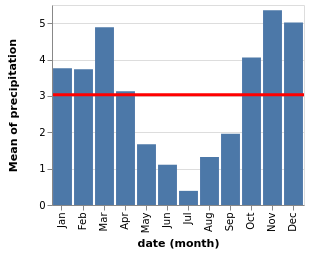

In [11]:
layerPrecipitationMean =
    let dvals = dataFromUrl "data/seattle-weather.csv" []
    
        posY = position Y [PName "precipitation", PmType Quantitative, PAggregate Mean]
        enc1 = encoding
                 . position X [PName "date", PmType Ordinal, PTimeUnit Month]
                 . posY
        enc2 = encoding
                 . posY
                 . color [MString "red"]
                 . size [MNumber 3]
    
        lyr1 = [mark Bar [], enc1 []]
        lyr2 = [mark Rule [], enc2 []]
        
        layers = layer (map asSpec [lyr1, lyr2])
        
    in toVegaLite [dvals, layers]
    
vlShow layerPrecipitationMean

In [12]:
validate layerPrecipitationMeanSpec layerPrecipitationMean

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Histogram with a Global Mean Overlay

From https://vega.github.io/vega-lite/examples/layer_histogram_global_mean.html

In [13]:
layerHistogramGlobalMeanSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "data": {"url": "data/movies.json"},
  "layer": [{
    "mark": "bar",
    "encoding": {
      "x": {
        "bin": true,
        "field": "IMDB_Rating",
        "type": "quantitative"
      },
      "y": {
        "aggregate": "count",
        "type": "quantitative"
      }
    }
  },{
    "mark": "rule",
    "encoding": {
      "x": {
        "aggregate": "mean",
        "field": "IMDB_Rating",
        "type": "quantitative"
      },
      "color": {"value": "red"},
      "size": {"value": 5}
    }
  }]
}
|]

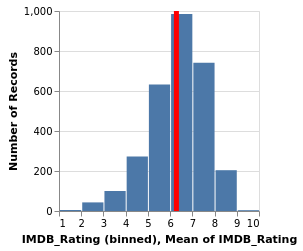

In [14]:
layerHistogramGlobalMean =
    let dvals = dataFromUrl "data/movies.json" []
    
        posX extra = position X ([PName "IMDB_Rating", PmType Quantitative] ++ extra)
        enc1 = encoding
                 . posX [PBin []]
                 . position Y [PAggregate Count, PmType Quantitative]
        enc2 = encoding
                 . posX [PAggregate Mean]
                 . color [MString "red"]
                 . size [MNumber 5]
                 
        lyr1 = [mark Bar [], enc1 []]
        lyr2 = [mark Rule [], enc2 []]
    
        layers = layer (map asSpec [lyr1, lyr2])
        
    in toVegaLite [dvals, layers]

vlShow layerHistogramGlobalMean

In [15]:
validate layerHistogramGlobalMeanSpec layerHistogramGlobalMean

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Line Chart with Highlighted Rectangles

From https://vega.github.io/vega-lite/examples/layer_falkensee.html

In [16]:
layerFalkenseeSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "description": "The population of the German city of Falkensee over time",
  "width": 500,
  "data": {
    "values": [
      {"year": "1875", "population": 1309},
      {"year": "1890", "population": 1558},
      {"year": "1910", "population": 4512},
      {"year": "1925", "population": 8180},
      {"year": "1933", "population": 15915},
      {"year": "1939", "population": 24824},
      {"year": "1946", "population": 28275},
      {"year": "1950", "population": 29189},
      {"year": "1964", "population": 29881},
      {"year": "1971", "population": 26007},
      {"year": "1981", "population": 24029},
      {"year": "1985", "population": 23340},
      {"year": "1989", "population": 22307},
      {"year": "1990", "population": 22087},
      {"year": "1991", "population": 22139},
      {"year": "1992", "population": 22105},
      {"year": "1993", "population": 22242},
      {"year": "1994", "population": 22801},
      {"year": "1995", "population": 24273},
      {"year": "1996", "population": 25640},
      {"year": "1997", "population": 27393},
      {"year": "1998", "population": 29505},
      {"year": "1999", "population": 32124},
      {"year": "2000", "population": 33791},
      {"year": "2001", "population": 35297},
      {"year": "2002", "population": 36179},
      {"year": "2003", "population": 36829},
      {"year": "2004", "population": 37493},
      {"year": "2005", "population": 38376},
      {"year": "2006", "population": 39008},
      {"year": "2007", "population": 39366},
      {"year": "2008", "population": 39821},
      {"year": "2009", "population": 40179},
      {"year": "2010", "population": 40511},
      {"year": "2011", "population": 40465},
      {"year": "2012", "population": 40905},
      {"year": "2013", "population": 41258},
      {"year": "2014", "population": 41777}
    ],
    "format": {
      "parse": {"year": "date:'%Y'"}
    }
  },
  "layer": [
    {
      "mark": "rect",
      "data": {
        "values": [
          {
            "start": "1933",
            "end": "1945",
            "event": "Nazi Rule"
          },
          {
            "start": "1948",
            "end": "1989",
            "event": "GDR (East Germany)"
          }
        ],
        "format": {
          "parse": {"start": "date:'%Y'", "end": "date:'%Y'"}
        }
      },
      "encoding": {
        "x": {
          "field": "start",
          "type": "temporal",
          "timeUnit": "year",
          "axis": null
        },
        "x2": {
          "field": "end",
          "timeUnit": "year"
        },
        "color": {"field": "event", "type": "nominal"}
      }
    },
    {
      "mark": "line",
      "encoding": {
        "x": {
          "field": "year",
          "type": "temporal",
          "timeUnit": "year"
        },
        "y": {"field": "population", "type": "quantitative"},
        "color": {"value": "#333"}
      }
    },
    {
      "mark": "point",
      "encoding": {
        "x": {
          "field": "year",
          "type": "temporal",
          "timeUnit": "year"
        },
        "y": {"field": "population", "type": "quantitative"},
        "color": {"value": "#333"}
      }
    }
  ]
}
|]

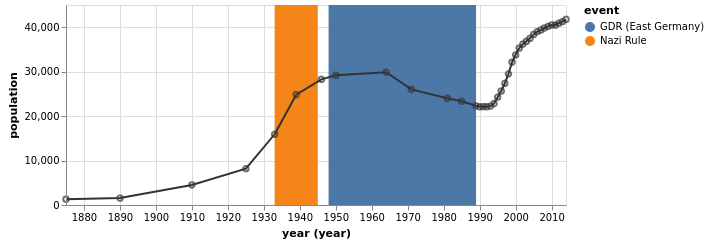

In [17]:
layerFalkensee =
    let desc = "The population of the German city of Falkensee over time"

        i2s = Str . T.pack . show
        rw y p = dataRow [("year", i2s y), ("population", Number p)]           
        dvals = dataFromRows [Parse [("year", FoDate "%Y")]]
                   . rw 1875 1309
                   . rw 1890 1558
                   . rw 1910 4512
                   . rw 1925 8180
                   . rw 1933 15915
                   . rw 1939 24824
                   . rw 1946 28275
                   . rw 1950 29189
                   . rw 1964 29881
                   . rw 1971 26007
                   . rw 1981 24029
                   . rw 1985 23340
                   . rw 1989 22307
                   . rw 1990 22087
                   . rw 1991 22139
                   . rw 1992 22105
                   . rw 1993 22242
                   . rw 1994 22801
                   . rw 1995 24273
                   . rw 1996 25640
                   . rw 1997 27393
                   . rw 1998 29505
                   . rw 1999 32124
                   . rw 2000 33791
                   . rw 2001 35297
                   . rw 2002 36179
                   . rw 2003 36829
                   . rw 2004 37493
                   . rw 2005 38376
                   . rw 2006 39008
                   . rw 2007 39366
                   . rw 2008 39821
                   . rw 2009 40179
                   . rw 2010 40511
                   . rw 2011 40465
                   . rw 2012 40905
                   . rw 2013 41258
                   . rw 2014 41777

        dvals1 = dataFromRows [Parse [("start", FoDate "%Y"), ("end", FoDate "%Y")]]
                    . dataRow [("start", Str "1933"), ("end", Str "1945"), ("event", Str "Nazi Rule")]
                    . dataRow [("start", Str "1948"), ("end", Str "1989"), ("event", Str "GDR (East Germany)")]
                 
        enc1 = encoding
                  . position X [PName "start", PmType Temporal, PTimeUnit Year, PAxis []]
                  . position X2 [PName "end", PTimeUnit Year]
                  . color [MName "event", MmType Nominal]
        enc2 = encoding
                  . position X [PName "year", PmType Temporal, PTimeUnit Year]
                  . position Y [PName "population", PmType Quantitative]
                  . color [MString "#333"]
      
        lyr1 = asSpec [mark Rect [], dvals1 [], enc1 []]
        lyr2 = asSpec [mark Line [], enc2 []]
        lyr3 = asSpec [mark Point [], enc2 []]


    in toVegaLite [description desc, width 500, dvals [], layer [lyr1, lyr2, lyr3]]

vlShow layerFalkensee

In [18]:
validate layerFalkenseeSpec layerFalkensee

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Layering Averages over Raw Values

From https://vega.github.io/vega-lite/examples/layer_line_mean_point_raw.html

In [19]:
layerLineMeanPointRawSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "description": "Plot showing average data with raw values in the background.",
  "data": {"url": "data/stocks.csv"},
  "transform": [{"filter": "datum.symbol==='GOOG'"}],
  "layer": [{
    "mark": {"type": "point", "opacity": 0.3},
    "encoding": {
      "x": {"timeUnit":"year", "field": "date", "type": "temporal"},
      "y": {"field": "price", "type": "quantitative"}
    }
  }, {
    "mark": "line",
    "encoding": {
      "x": {"timeUnit":"year", "field": "date", "type": "temporal"},
      "y": {"aggregate": "mean", "field": "price", "type": "quantitative"}
    }
  }]
}
|]

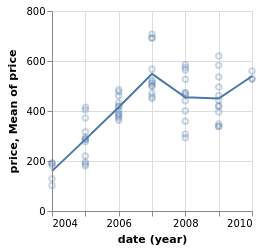

In [20]:
layerLineMeanPointRaw =
    let label = description "Plot showing average data with raw values in the background."
        dvals = dataFromUrl "data/stocks.csv" []
        
        trans = transform (filter (FExpr "datum.symbol==='GOOG'") [])
        
        posX = position X [PName "date", PmType Temporal, PTimeUnit Year]
        posY extra = position Y ([PName "price", PmType Quantitative] ++ extra)
        
        enc1 = encoding (posX (posY [] []))
        enc2 = encoding (posX (posY [PAggregate Mean] []))
                 
        lyr1 = [mark Point [MOpacity 0.3], enc1]
        lyr2 = [mark Line [], enc2]
        
        lyr = layer (map asSpec [lyr1, lyr2])
        
    in toVegaLite [label, dvals, trans, lyr]

vlShow layerLineMeanPointRaw

In [21]:
validate layerLineMeanPointRawSpec layerLineMeanPointRaw

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Layering Rolling Averages over Raw Values

From https://vega.github.io/vega-lite/examples/layer_line_rolling_mean_point_raw.html

In [22]:
layerLineRollingMeanPointRawSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "description": "Plot showing a 30 day rolling average with raw values in the background.",
  "width": 400,
  "height": 300,
  "data": {"url": "data/seattle-weather.csv"},
  "transform": [{
      "frame": [-15, 15],
      "window": [
        {
          "field": "temp_max",
          "op": "mean",
          "as": "rolling_mean"
        }
      ]
    }
  ],
  "layer": [
    {
      "mark": {"type": "point", "opacity": 0.3},
      "encoding": {
        "x": {
          "title": "Date",
          "field": "date",
          "type": "temporal"
        },
        "y": {
          "title": "Max Temperature",
          "field": "temp_max",
          "type": "quantitative"
        }
      }
    },
    {
      "mark": {
        "color": "red",
        "size": 3,
        "type": "line"
      },
      "encoding": {
        "x": {
          "field": "date",
          "type": "temporal"
        },
        "y": {
          "field": "rolling_mean",
          "type": "quantitative"
        }
      }
    }
  ]
}
|]

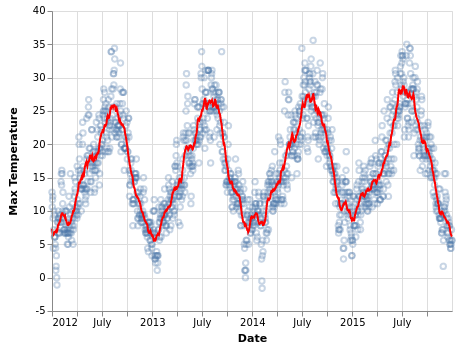

In [23]:
layerLineRollingMeanPointRaw =
    let label = description "Plot showing a 30 day rolling average with raw values in the background."
        dvals = dataFromUrl "data/seattle-weather.csv" [] 
        
        trans = transform
                  . window [([WField "temp_max", WAggregateOp Mean], "rolling_mean")]
                           [WFrame (Just (-15)) (Just 15)]
        
        enc1 = encoding
                 . position X [PName "date", PmType Temporal, PTitle "Date"]
                 . position Y [PName "temp_max", PmType Quantitative, PTitle "Max Temperature"]
        enc2 = encoding
                 . position X [PName "date", PmType Temporal]
                 . position Y [PName "rolling_mean", PmType Quantitative]
        lyr1 = [mark Point [MOpacity 0.3], enc1 []]
        lyr2 = [mark Line [MColor "red", MSize 3], enc2 []]
        
        lyr = layer (map asSpec [lyr1, lyr2])

    in toVegaLite [label, height 300, width 400, dvals, trans [], lyr]

vlShow layerLineRollingMeanPointRaw

In [24]:
validate layerLineRollingMeanPointRawSpec layerLineRollingMeanPointRaw

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Distributions and Medians of Likert Scale Ratings

From https://vega.github.io/vega-lite/examples/layer_likert.html

In [25]:
layerLikertSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "description": "Likert Scale Ratings Distributions and Medians. (Figure 9 from @jhoffswell and @zcliu's ['Interactive Repair of Tables Extracted from PDF Documents on Mobile Devices'](https://idl.cs.washington.edu/files/2019-InteractiveTableRepair-CHI.pdf))",
  "datasets": {
    "medians": [
      {"name": "Identify Errors:", "median": 1.999976, "lo": "Easy", "hi": "Hard"},
      {"name": "Fix Errors:", "median": 2, "lo": "Easy", "hi": "Hard"},
      {"name": "Easier to Fix:", "median": 1.999969, "lo": "Toolbar", "hi": "Gesture"},
      {"name": "Faster to Fix:", "median": 2.500045, "lo": "Toolbar", "hi": "Gesture"},
      {"name": "Easier on Phone:", "median": 1.500022, "lo": "Toolbar", "hi": "Gesture"},
      {"name": "Easier on Tablet:", "median": 2.99998, "lo": "Toolbar", "hi": "Gesture"},
      {"name": "Device Preference:", "median": 4.500007, "lo": "Phone", "hi": "Tablet"}
    ],
    "values": [
      {"value": "P1", "name": "Participant ID", "id": "P1"},
      {"value": 2, "name": "Identify Errors:", "id": "P1"},
      {"value": 2, "name": "Fix Errors:", "id": "P1"},
      {"value": 3, "name": "Easier to Fix:", "id": "P1"},
      {"value": 4, "name": "Faster to Fix:", "id": "P1"},
      {"value": 2, "name": "Easier on Phone:", "id": "P1"},
      {"value": 5, "name": "Easier on Tablet:", "id": "P1"},
      {"value": 5, "name": "Device Preference:", "id": "P1"},
      {"value": 1, "name": "Tablet_First", "id": "P1"},
      {"value": 1, "name": "Toolbar_First", "id": "P1"},
      {"value": "P2", "name": "Participant ID", "id": "P2"},
      {"value": 2, "name": "Identify Errors:", "id": "P2"},
      {"value": 3, "name": "Fix Errors:", "id": "P2"},
      {"value": 4, "name": "Easier to Fix:", "id": "P2"},
      {"value": 5, "name": "Faster to Fix:", "id": "P2"},
      {"value": 5, "name": "Easier on Phone:", "id": "P2"},
      {"value": 5, "name": "Easier on Tablet:", "id": "P2"},
      {"value": 5, "name": "Device Preference:", "id": "P2"},
      {"value": 1, "name": "Tablet_First", "id": "P2"},
      {"value": 1, "name": "Toolbar_First", "id": "P2"},
      {"value": "P3", "name": "Participant ID", "id": "P3"},
      {"value": 2, "name": "Identify Errors:", "id": "P3"},
      {"value": 2, "name": "Fix Errors:", "id": "P3"},
      {"value": 2, "name": "Easier to Fix:", "id": "P3"},
      {"value": 1, "name": "Faster to Fix:", "id": "P3"},
      {"value": 2, "name": "Easier on Phone:", "id": "P3"},
      {"value": 1, "name": "Easier on Tablet:", "id": "P3"},
      {"value": 5, "name": "Device Preference:", "id": "P3"},
      {"value": 1, "name": "Tablet_First", "id": "P3"},
      {"value": 0, "name": "Toolbar_First", "id": "P3"},
      {"value": "P4", "name": "Participant ID", "id": "P4"},
      {"value": 3, "name": "Identify Errors:", "id": "P4"},
      {"value": 3, "name": "Fix Errors:", "id": "P4"},
      {"value": 2, "name": "Easier to Fix:", "id": "P4"},
      {"value": 2, "name": "Faster to Fix:", "id": "P4"},
      {"value": 4, "name": "Easier on Phone:", "id": "P4"},
      {"value": 1, "name": "Easier on Tablet:", "id": "P4"},
      {"value": 5, "name": "Device Preference:", "id": "P4"},
      {"value": 1, "name": "Tablet_First", "id": "P4"},
      {"value": 0, "name": "Toolbar_First", "id": "P4"},
      {"value": "P5", "name": "Participant ID", "id": "P5"},
      {"value": 2, "name": "Identify Errors:", "id": "P5"},
      {"value": 2, "name": "Fix Errors:", "id": "P5"},
      {"value": 4, "name": "Easier to Fix:", "id": "P5"},
      {"value": 4, "name": "Faster to Fix:", "id": "P5"},
      {"value": 4, "name": "Easier on Phone:", "id": "P5"},
      {"value": 5, "name": "Easier on Tablet:", "id": "P5"},
      {"value": 5, "name": "Device Preference:", "id": "P5"},
      {"value": 0, "name": "Tablet_First", "id": "P5"},
      {"value": 1, "name": "Toolbar_First", "id": "P5"},
      {"value": "P6", "name": "Participant ID", "id": "P6"},
      {"value": 1, "name": "Identify Errors:", "id": "P6"},
      {"value": 3, "name": "Fix Errors:", "id": "P6"},
      {"value": 3, "name": "Easier to Fix:", "id": "P6"},
      {"value": 4, "name": "Faster to Fix:", "id": "P6"},
      {"value": 4, "name": "Easier on Phone:", "id": "P6"},
      {"value": 4, "name": "Easier on Tablet:", "id": "P6"},
      {"value": 4, "name": "Device Preference:", "id": "P6"},
      {"value": 0, "name": "Tablet_First", "id": "P6"},
      {"value": 1, "name": "Toolbar_First", "id": "P6"},
      {"value": "P7", "name": "Participant ID", "id": "P7"},
      {"value": 2, "name": "Identify Errors:", "id": "P7"},
      {"value": 3, "name": "Fix Errors:", "id": "P7"},
      {"value": 4, "name": "Easier to Fix:", "id": "P7"},
      {"value": 5, "name": "Faster to Fix:", "id": "P7"},
      {"value": 3, "name": "Easier on Phone:", "id": "P7"},
      {"value": 2, "name": "Easier on Tablet:", "id": "P7"},
      {"value": 4, "name": "Device Preference:", "id": "P7"},
      {"value": 0, "name": "Tablet_First", "id": "P7"},
      {"value": 0, "name": "Toolbar_First", "id": "P7"},
      {"value": "P8", "name": "Participant ID", "id": "P8"},
      {"value": 3, "name": "Identify Errors:", "id": "P8"},
      {"value": 1, "name": "Fix Errors:", "id": "P8"},
      {"value": 2, "name": "Easier to Fix:", "id": "P8"},
      {"value": 4, "name": "Faster to Fix:", "id": "P8"},
      {"value": 2, "name": "Easier on Phone:", "id": "P8"},
      {"value": 5, "name": "Easier on Tablet:", "id": "P8"},
      {"value": 5, "name": "Device Preference:", "id": "P8"},
      {"value": 0, "name": "Tablet_First", "id": "P8"},
      {"value": 0, "name": "Toolbar_First", "id": "P8"},
      {"value": "P9", "name": "Participant ID", "id": "P9"},
      {"value": 2, "name": "Identify Errors:", "id": "P9"},
      {"value": 3, "name": "Fix Errors:", "id": "P9"},
      {"value": 2, "name": "Easier to Fix:", "id": "P9"},
      {"value": 4, "name": "Faster to Fix:", "id": "P9"},
      {"value": 1, "name": "Easier on Phone:", "id": "P9"},
      {"value": 4, "name": "Easier on Tablet:", "id": "P9"},
      {"value": 4, "name": "Device Preference:", "id": "P9"},
      {"value": 1, "name": "Tablet_First", "id": "P9"},
      {"value": 1, "name": "Toolbar_First", "id": "P9"},
      {"value": "P10", "name": "Participant ID", "id": "P10"},
      {"value": 2, "name": "Identify Errors:", "id": "P10"},
      {"value": 2, "name": "Fix Errors:", "id": "P10"},
      {"value": 1, "name": "Easier to Fix:", "id": "P10"},
      {"value": 1, "name": "Faster to Fix:", "id": "P10"},
      {"value": 1, "name": "Easier on Phone:", "id": "P10"},
      {"value": 1, "name": "Easier on Tablet:", "id": "P10"},
      {"value": 5, "name": "Device Preference:", "id": "P10"},
      {"value": 1, "name": "Tablet_First", "id": "P10"},
      {"value": 1, "name": "Toolbar_First", "id": "P10"},
      {"value": "P11", "name": "Participant ID", "id": "P11"},
      {"value": 2, "name": "Identify Errors:", "id": "P11"},
      {"value": 2, "name": "Fix Errors:", "id": "P11"},
      {"value": 1, "name": "Easier to Fix:", "id": "P11"},
      {"value": 1, "name": "Faster to Fix:", "id": "P11"},
      {"value": 1, "name": "Easier on Phone:", "id": "P11"},
      {"value": 1, "name": "Easier on Tablet:", "id": "P11"},
      {"value": 4, "name": "Device Preference:", "id": "P11"},
      {"value": 1, "name": "Tablet_First", "id": "P11"},
      {"value": 0, "name": "Toolbar_First", "id": "P11"},
      {"value": "P12", "name": "Participant ID", "id": "P12"},
      {"value": 1, "name": "Identify Errors:", "id": "P12"},
      {"value": 3, "name": "Fix Errors:", "id": "P12"},
      {"value": 2, "name": "Easier to Fix:", "id": "P12"},
      {"value": 3, "name": "Faster to Fix:", "id": "P12"},
      {"value": 1, "name": "Easier on Phone:", "id": "P12"},
      {"value": 3, "name": "Easier on Tablet:", "id": "P12"},
      {"value": 3, "name": "Device Preference:", "id": "P12"},
      {"value": 0, "name": "Tablet_First", "id": "P12"},
      {"value": 1, "name": "Toolbar_First", "id": "P12"},
      {"value": "P13", "name": "Participant ID", "id": "P13"},
      {"value": 2, "name": "Identify Errors:", "id": "P13"},
      {"value": 2, "name": "Fix Errors:", "id": "P13"},
      {"value": 1, "name": "Easier to Fix:", "id": "P13"},
      {"value": 1, "name": "Faster to Fix:", "id": "P13"},
      {"value": 1, "name": "Easier on Phone:", "id": "P13"},
      {"value": 1, "name": "Easier on Tablet:", "id": "P13"},
      {"value": 5, "name": "Device Preference:", "id": "P13"},
      {"value": 0, "name": "Tablet_First", "id": "P13"},
      {"value": 0, "name": "Toolbar_First", "id": "P13"},
      {"value": "P14", "name": "Participant ID", "id": "P14"},
      {"value": 3, "name": "Identify Errors:", "id": "P14"},
      {"value": 3, "name": "Fix Errors:", "id": "P14"},
      {"value": 2, "name": "Easier to Fix:", "id": "P14"},
      {"value": 2, "name": "Faster to Fix:", "id": "P14"},
      {"value": 1, "name": "Easier on Phone:", "id": "P14"},
      {"value": 1, "name": "Easier on Tablet:", "id": "P14"},
      {"value": 1, "name": "Device Preference:", "id": "P14"},
      {"value": 1, "name": "Tablet_First", "id": "P14"},
      {"value": 1, "name": "Toolbar_First", "id": "P14"},
      {"value": "P15", "name": "Participant ID", "id": "P15"},
      {"value": 4, "name": "Identify Errors:", "id": "P15"},
      {"value": 5, "name": "Fix Errors:", "id": "P15"},
      {"value": 1, "name": "Easier to Fix:", "id": "P15"},
      {"value": 1, "name": "Faster to Fix:", "id": "P15"},
      {"value": 1, "name": "Easier on Phone:", "id": "P15"},
      {"value": 1, "name": "Easier on Tablet:", "id": "P15"},
      {"value": 5, "name": "Device Preference:", "id": "P15"},
      {"value": 1, "name": "Tablet_First", "id": "P15"},
      {"value": 0, "name": "Toolbar_First", "id": "P15"},
      {"value": "P16", "name": "Participant ID", "id": "P16"},
      {"value": 1, "name": "Identify Errors:", "id": "P16"},
      {"value": 3, "name": "Fix Errors:", "id": "P16"},
      {"value": 2, "name": "Easier to Fix:", "id": "P16"},
      {"value": 2, "name": "Faster to Fix:", "id": "P16"},
      {"value": 1, "name": "Easier on Phone:", "id": "P16"},
      {"value": 4, "name": "Easier on Tablet:", "id": "P16"},
      {"value": 5, "name": "Device Preference:", "id": "P16"},
      {"value": 0, "name": "Tablet_First", "id": "P16"},
      {"value": 1, "name": "Toolbar_First", "id": "P16"},
      {"value": "P17", "name": "Participant ID", "id": "P17"},
      {"value": 3, "name": "Identify Errors:", "id": "P17"},
      {"value": 2, "name": "Fix Errors:", "id": "P17"},
      {"value": 2, "name": "Easier to Fix:", "id": "P17"},
      {"value": 2, "name": "Faster to Fix:", "id": "P17"},
      {"value": 1, "name": "Easier on Phone:", "id": "P17"},
      {"value": 3, "name": "Easier on Tablet:", "id": "P17"},
      {"value": 2, "name": "Device Preference:", "id": "P17"},
      {"value": 0, "name": "Tablet_First", "id": "P17"},
      {"value": 0, "name": "Toolbar_First", "id": "P17"}
    ]
  },
  "data": {"name": "medians"},
  "title": "Questionnaire Ratings",
  "width": 250,
  "height": 175,
  "encoding": {
    "y": {
      "field": "name",
      "type": "nominal",
      "sort": null,
      "axis": {
        "domain": false,
        "offset": 50,
        "labelFontWeight": "bold",
        "ticks": false,
        "grid": true,
        "title": null
      }
    }
  },
  "view": {"stroke": null},
  "layer": [
    {
      "mark": "circle",
      "data": {"name": "values"},
      "transform": [
        {"filter": "datum.name != 'Toolbar_First'"},
        {"filter": "datum.name != 'Tablet_First'"},
        {"filter": "datum.name != 'Participant ID'"}
      ],
      "encoding": {
        "x": {
          "field": "value",
          "type": "quantitative",
          "scale": {"domain": [0, 6]},
          "axis": {"grid": false, "values": [1, 2, 3, 4, 5]}
        },
        "size": {
          "aggregate": "count",
          "type": "quantitative",
          "legend": {"title": "Number of Ratings", "offset": 75}
        },
        "color": {"value": "#6EB4FD"}
      }
    },
    {
      "mark": "tick",
      "encoding": {
        "x": {
          "field": "median",
          "type": "quantitative",
          "axis": {"title": null}
        },
        "color": {"value": "black"}
      }
    },
    {
      "mark": {"type": "text", "x": -5, "align": "right"},
      "encoding": {
        "text": {"field": "lo", "type": "nominal"}
      }
    },
    {
      "mark": {"type": "text", "x": 255, "align": "left"},
      "encoding": {
        "text": {"field": "hi", "type": "nominal"}
      }
    }
  ]
}
|]

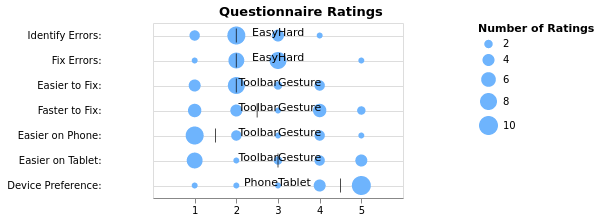

In [26]:
data Errors = IE | FE | EF | FF | EP | ET | DP | TBL | TBR

fromE IE = "Identify Errors:"
fromE FE = "Fix Errors:"
fromE EF = "Easier to Fix:"
fromE FF = "Faster to Fix:"
fromE EP = "Easier on Phone:"
fromE ET = "Easier on Tablet:"
fromE DP = "Device Preference:"
fromE TBL = "Tablet_First"
fromE TBR = "Toolbar_First"

layerLikert =
    let label = description "Likert Scale Ratings Distributions and Medians. (Figure 9 from @jhoffswell and @zcliu's ['Interactive Repair of Tables Extracted from PDF Documents on Mobile Devices'](https://idl.cs.washington.edu/files/2019-InteractiveTableRepair-CHI.pdf))"
        titleOpt = title "Questionnaire Ratings" []
        viewOpt = viewBackground [VBNoStroke]

        mData = [ (IE, 1.999976, "Easy", "Hard")
                , (FE, 2, "Easy", "Hard")
                , (EF, 1.999969, "Toolbar", "Gesture")
                , (FF, 2.500045, "Toolbar", "Gesture")
                , (EP, 1.500022, "Toolbar", "Gesture")
                , (ET, 2.99998, "Toolbar", "Gesture")
                , (DP, 4.500007, "Phone", "Tablet") ]
        mRow (name, med, lo, hi) = dataRow [("name", Str (fromE name)), ("median", Number med), ("lo", Str lo), ("hi", Str hi)]
        medians = dataFromRows [] (foldr mRow [] mData)

        vData = [ ("P1", [2, 2, 3, 4, 2, 5, 5, 1, 1])
                , ("P2", [2, 3, 4, 5, 5, 5, 5, 1, 1])
                , ("P3", [2, 2, 2, 1, 2, 1, 5, 1, 0])
                , ("P4", [3, 3, 2, 2, 4, 1, 5, 1, 0])
                , ("P5", [2, 2, 4, 4, 4, 5, 5, 0, 1])
                , ("P6", [1, 3, 3, 4, 4, 4, 4, 0, 1])
                , ("P7", [2, 3, 4, 5, 3, 2, 4, 0, 0])
                , ("P8", [3, 1, 2, 4, 2, 5, 5, 0, 0])
                , ("P9", [2, 3, 2, 4, 1, 4, 4, 1, 1])
                , ("P10", [2, 2, 1, 1, 1, 1, 5, 1, 1])
                , ("P11", [2, 2, 1, 1, 1, 1, 4, 1, 0])
                , ("P12", [1, 3, 2, 3, 1, 3, 3, 0, 1])
                , ("P13", [2, 2, 1, 1, 1, 1, 5, 0, 0])
                , ("P14", [3, 3, 2, 2, 1, 1, 1, 1, 1])
                , ("P15", [4, 5, 1, 1, 1, 1, 5, 1, 0])
                , ("P16", [1, 3, 2, 2, 1, 4, 5, 0, 1])
                , ("P17", [3, 2, 2, 2, 1, 3, 2, 0, 0])
                ]

        names = [IE, FE, EF, FF, EP, ET, DP, TBL, TBR]
        v1Row pid = dataRow [("value", Str pid), ("name", Str "Participant ID"), ("id", Str pid)]
        v2Row pid (value, name) = dataRow [("value", Number value), ("name", Str (fromE name)), ("id", Str pid)]
        vRow (pid, vs) = v1Row pid (foldr (v2Row pid) [] (zip vs names)) 
        values = dataFromRows [] (concatMap vRow vData)
        
        dsets = datasets [("medians", medians), ("values", values)]
        yAxis = [AxDomain False, AxOffset 50, AxLabelFontWeight Bold, AxTicks False, AxGrid True, AxNoTitle]
        enc = encoding
                . position Y [PName "name", PmType Nominal, PSort [], PAxis yAxis]

        trans1 = transform
                   . filter (FExpr "datum.name != 'Toolbar_First'")
                   . filter (FExpr "datum.name != 'Tablet_First'")
                   . filter (FExpr "datum.name != 'Participant ID'")
        enc1 = encoding
                  . position X [ PName "value", PmType Quantitative
                               , PScale [SDomain (DNumbers [0, 6])]
                               , PAxis [AxGrid False, AxValues (Numbers [1, 2, 3, 4, 5])]
                               ]
                  . size [ MAggregate Count, MmType Quantitative
                         , MLegend [LTitle "Number of Ratings", LOffset 75]
                         ]
                  . color [MString "#6EB4FD"]                  
        lyr1 = [mark Circle [], dataFromSource "values" [], trans1 [], enc1 []]

        enc2 = encoding
                 . position X [ PName "median", PmType Quantitative
                              , PAxis [AxNoTitle]
                              ]
                 . color [MString "black"]
        lyr2 = [mark Tick [], enc2 []]

        lyr3 = [ mark Text [MX (-5), MAlign AlignRight]
               , encoding (text [TName "lo", TmType Nominal] [])
               ]
               
        lyr4 = [ mark Text [MX 255, MAlign AlignLeft]
               , encoding (text [TName "hi", TmType Nominal] [])
               ]
               
        lyr = layer (map asSpec [lyr1, lyr2, lyr3, lyr4])
        vlOpts = [ label, titleOpt, height 175, width 250, viewOpt
                 , enc [], dsets, dsets, dataFromSource "medians" []
                 , lyr
                 ]
         
    in toVegaLite vlOpts
    
vlShow layerLikert

In [27]:
validate layerLikertSpec layerLikert

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Comparative Likert Scale Ratings

From https://vega.github.io/vega-lite/examples/concat_layer_voyager_result.html

In [28]:
concatLayerVoyagerResultSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "data": {
    "values": [
      {
        "measure": "Open Exploration",
        "mean": 1.813,
        "lo": 1.255,
        "hi": 2.37,
        "study": "PoleStar vs Voyager"
      },
      {
        "measure": "Focused Question Answering",
        "mean": -1.688,
        "lo": -2.325,
        "hi": -1.05,
        "study": "PoleStar vs Voyager"
      },
      {
        "measure": "Open Exploration",
        "mean": 2.1875,
        "lo": 1.665,
        "hi": 2.71,
        "study": "PoleStar vs Voyager 2"
      },
      {
        "measure": "Focused Question Answering",
        "mean": -0.0625,
        "lo": -0.474,
        "hi": 0.349,
        "study": "PoleStar vs Voyager 2"
      }
    ]
  },
  "spacing": 10,
  "vconcat": [
    {
      "title": {
        "text": "Mean of Subject Ratings (95% CIs)",
        "frame": "bounds"
      },
      "encoding": {
        "y": {
          "field": "study",
          "type": "nominal",
          "axis": {
            "title": null,
            "labelPadding": 5,
            "domain": false,
            "ticks": false,
            "grid": false
          }
        }
      },
      "layer": [
        {
          "mark": "rule",
          "encoding": {
            "x": {
              "field": "lo",
              "type": "quantitative",
              "scale": {"domain": [-3, 3]},
              "axis": {
                "title": "",
                "gridDash": [3, 3],
                "gridColor": {
                  "condition": {
                    "test": "datum.value === 0",
                    "value": "#666"
                  },
                  "value": "#CCC"
                }
              }
            },
            "x2": {"field": "hi"}
          }
        },
        {
          "mark": {
            "type": "circle",
            "stroke": "black",
            "opacity": 1
          },
          "encoding": {
            "x": {
              "field": "mean",
              "type": "quantitative"
            },
            "color": {
              "field": "measure",
              "type": "nominal",
              "scale": {
                "range": ["black", "white"]
              },
              "legend": null
            }
          }
        }
      ]
    },
    {
      "data": {
        "values": [
          {
            "from": -0.25,
            "to": -2.9,
            "label": "PoleStar"
          },
          {
            "from": 0.25,
            "to": 2.9,
            "label": "Voyager / Voyager 2"
          }
        ]
      },
      "layer": [
        {
          "mark": "rule",
          "encoding": {
            "x": {
              "field": "from",
              "type": "quantitative",
              "scale": {
                "zero": false
              },
              "axis": null
            },
            "x2": {"field": "to"}
          }
        },
        {
          "mark": {
            "type": "point",
            "filled": true,
            "size": 60,
            "fill": "black"
          },
          "encoding": {
            "x": {
              "field": "to",
              "type": "quantitative",
              "axis": null
            },
            "shape": {
              "condition": {
                "test": "datum.to > 0",
                "value": "triangle-right"
              },
              "value": "triangle-left"
            }
          }
        },
        {
          "mark": {
            "type": "text",
            "align": "right",
            "style": "arrow-label",
            "text": ["Polestar", "More Valuable"]
          },
          "transform": [{"filter": "datum.label === 'PoleStar'"}],
          "encoding": {
            "x": {
              "field": "from",
              "type": "quantitative",
              "axis": null
            }
          }
        },
        {
          "mark": {
            "type": "text",
            "align": "left",
            "style": "arrow-label",
            "text": ["Voyager / Voyager 2", "More Valuable"]
          },
          "transform": [{"filter": "datum.label !== 'PoleStar'"}],
          "encoding": {
            "x": {
              "field": "from",
              "type": "quantitative",
              "axis": null
            }
          }
        }
      ]
    }
  ],
  "config": {
    "view": {"stroke": "transparent"},
    "style": {
      "arrow-label": {"dy": 12, "fontSize": 9.5},
      "arrow-label2": {"dy": 24, "fontSize": 9.5}
    },
    "title": {"fontSize": 12}
  }
}
|]

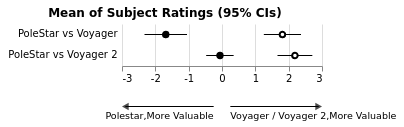

In [29]:
voyagerData = [aesonQQ|
[
      {
        "measure": "Open Exploration",
        "mean": 1.813,
        "lo": 1.255,
        "hi": 2.37,
        "study": "PoleStar vs Voyager"
      },
      {
        "measure": "Focused Question Answering",
        "mean": -1.688,
        "lo": -2.325,
        "hi": -1.05,
        "study": "PoleStar vs Voyager"
      },
      {
        "measure": "Open Exploration",
        "mean": 2.1875,
        "lo": 1.665,
        "hi": 2.71,
        "study": "PoleStar vs Voyager 2"
      },
      {
        "measure": "Focused Question Answering",
        "mean": -0.0625,
        "lo": -0.474,
        "hi": 0.349,
        "study": "PoleStar vs Voyager 2"
      }]
|]

concatLayerVoyagerResult =
    let dataPlot = [ title "Mean of Subject Ratings (95% CIs)" [TFrame FrBounds]
                   , encoding
                     . position Y [ PName "study"
                                  , PmType Nominal
                                  , PAxis [ AxNoTitle
                                          , AxLabelPadding 5
                                          , AxDomain False
                                          , AxTicks False
                                          , AxGrid False
                                          ]
                                  ]
                     $ []
                   , layer [asSpec rulePlot, asSpec circlePlot]
                   ]
                   
        gridColor = AxDataCondition (Expr "datum.value === 0")
                                    (CAxGridColor "#666" "#CCC")
        rulePlot = [ mark Rule []
                   , encoding
                     . position X [ PName "lo"
                                  , PmType Quantitative
                                  , PScale [SDomain (DNumbers [-3, 3])]
                                  , PAxis [ AxTitle ""
                                          , AxGridDash [3, 3]
                                          , gridColor
                                          ]
                                  ]
                     . position X2 [PName "hi"]
                     $ []
                   ]
 
        circlePlot = [ mark Circle [MStroke "black", MOpacity 1]
                     , encoding
                       . position X [PName "mean", PmType Quantitative]
                       . color [ MName "measure"
                               , MmType Nominal
                               , MScale [SRange (RStrings ["black", "white"])]
                               , MLegend []
                               ]
                       $ []
                     ]
        
        labelPlot = [ dataFromColumns []
                      . dataColumn "from" (Numbers [-0.25, 0.25])
                      . dataColumn "to" (Numbers [-2.9, 2.9])
                      . dataColumn "label" (Strings ["PoleStar", "Voyager / Voyager 2"])
                      $ []
                    , layer (map asSpec [linePlot, arrowsPlot, pTextPlot, vTextPlot])
                    ]
                    
        linePlot = [ mark Rule []
                   , encoding
                     . position X [ PName "from"
                                  , PmType Quantitative
                                  , PScale [SZero False]
                                  , PAxis []
                                  ]
                     . position X2 [PName "to"]
                     $ []
                   ]
                   
        shapeOpts = MDataCondition
                    [(Expr "datum.to > 0", [MSymbol SymTriangleRight])]
                    [MSymbol SymTriangleLeft]
                    
        arrowsPlot = [ mark Point [ MFilled True
                                  , MFill "black"
                                  , MSize 60 ]
                     , encoding
                       . position X [ PName "to"
                                    , PmType Quantitative
                                    , PAxis []
                                    ]
                       . shape [ shapeOpts ]
                       $ []
                     ]

        from = position X [PName "from", PmType Quantitative, PAxis []]
        pTextPlot = [ mark Text [ MAlign AlignRight
                                , MStyle ["arrow-label"]
                                , MTexts ["Polestar", "More Valuable"]
                                ]
                    , transform
                      . filter (FExpr "datum.label === 'PoleStar'")
                      $ []
                    , encoding
                      . from
                      $ []
                    ]
        vTextPlot = [ mark Text [ MAlign AlignLeft
                                , MStyle ["arrow-label"]
                                , MTexts ["Voyager / Voyager 2", "More Valuable"]
                                ]
                    , transform
                      . filter (FExpr "datum.label !== 'PoleStar'")
                      $ []
                    , encoding
                      . from
                      $ []
                    ]
                  
        styles = MarkNamedStyles
                 [ ("arrow-label", [MdY 12, MFontSize 9.5])
                 , ("arrow-label2", [MdY 24, MFontSize 9.5])
                 ]
        conf = configure
               . configuration (ViewStyle [ViewStroke "transparent"])
               . configuration styles
               . configuration (TitleStyle [TFontSize 12])

        v = [ dataFromJson voyagerData []
            , spacing 10
            , vConcat [asSpec dataPlot, asSpec labelPlot]
            , conf []
            ]
            
    in toVegaLite v

vlShow concatLayerVoyagerResult

In [30]:
validate concatLayerVoyagerResultSpec concatLayerVoyagerResult

Okay

Return to the [Table of Contents](#Table-of-Contents).

---
 
## Other Layered Plots

 - [Candlestick Chart](#Candlestick-Chart)
 - [Ranged Dot Plot](#Ranged-Dot-Plot)
 - [Bullet Chart](#Bullet-Chart)
 - [Layered Plot with Dual-Axis](#Layered-PLot-with-Dual-Axis)
 - Horizon Graph (repeat)
 - [Weekly Weather Plot](#Weekly-Weather-Plot)
 - [Wheat and Wages Example](#Wheat-and-Wages-Example)

---

### Candlestick Chart

From https://vega.github.io/vega-lite/examples/layer_candlestick.html

I have removed the repeated X-axis label - `Date in 2009` - from the JSON (it is specified both as the `title` and the `axis.title` field in the URL above at the time of writing).

In [31]:
layerCandlestickSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 400,
  "description": "A candlestick chart inspired by an example in Protovis (http://mbostock.github.io/protovis/ex/candlestick.html)",
  "data": {"url": "data/ohlc.json"},
  "encoding": {
    "x": {
      "field": "date", 
      "type": "temporal", 
      "title": "Date in 2009",
      "axis": {
            "format": "%m/%d",
            "labelAngle": -45
          }
      },
    "color": {
      "condition": {
        "test": "datum.open < datum.close",
        "value": "#06982d"
      },
      "value": "#ae1325"
    }
  },
  "layer": [
    {
      "mark": "rule",
      "encoding": {
        "y": {
          "field": "low", "type": "quantitative",
          "scale": {"zero": false},
          "title": "Price"

        },
        "y2": {"field": "high"}
      }
    },
    {
      "mark": "bar",
      "encoding": {
        "y": {"field": "open", "type": "quantitative"},
        "y2": {"field": "close"}
      }
    }
  ]
}
|]

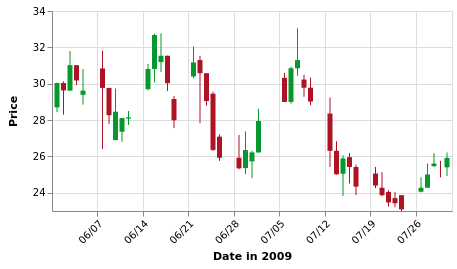

In [32]:
layerCandlestick =
    let desc = "A candlestick chart inspired by an example in Protovis (http://mbostock.github.io/protovis/ex/candlestick.html)"

        dvals = dataFromUrl "data/ohlc.json"

        start = [DTYear 2009, DTMonth May, DTDate 31]
        end = [DTYear 2009, DTMonth Jul, DTDate 1]
        enc = encoding
                 . position X [ PName "date"
                              , PmType Temporal
                              , PTitle "Date in 2009"
                              , PAxis [ AxFormat "%m/%d"
                                      , AxLabelAngle (-45)
                                      ]
                              ]
                 . color [ MDataCondition
                             [(Expr "datum.open < datum.close", [MString "#06982d"])]
                             [MString "#ae1325"]
                         ]
                        
        enc1 = encoding
                  . position Y [ PName "low"
                               , PmType Quantitative
                               , PScale [SZero False]
                               , PTitle "Price"
                               ]
                  . position Y2 [PName "high"]
        enc2 = encoding
                  . position Y [PName "open", PmType Quantitative]
                  . position Y2 [PName "close"]
           
        lyr1 = asSpec [mark Rule [], enc1 []]
        lyr2 = asSpec [mark Bar [], enc2 []]
        
    in toVegaLite [ description desc
                  , width 400
                  , dvals []
                  , enc []
                  , layer [lyr1, lyr2]
                  ]

vlShow layerCandlestick

In [33]:
validate layerCandlestickSpec layerCandlestick

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Ranged Dot Plot

From https://vega.github.io/vega-lite/examples/layer_ranged_dot.html

In [34]:
layerRangedDotSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "description": "A ranged dot plot that uses 'layer' to convey changing life expectancy for the five most populous countries (between 1955 and 2000).",
  "data": {"url": "data/countries.json"},
  "transform": [
    {
      "filter": {
        "field": "country",
        "oneOf": ["China", "India", "United States", "Indonesia", "Brazil"]
      }
    },
    {
      "filter": {
        "field": "year",
        "oneOf": [1955, 2000]
      }
    }
  ],
  "encoding": {
    "x": {
      "field": "life_expect",
      "type": "quantitative",
      "axis": {
        "title": "Life Expectancy (years)"
      }
    },
    "y": {
      "field": "country",
      "type": "nominal",
      "axis": {
        "title": "Country",
        "offset": 5,
        "ticks": false,
        "minExtent": 70,
        "domain": false
      }
    }
  },
  "layer": [
    {
      "mark": "line",
      "encoding": {
        "detail": {
          "field": "country",
          "type": "nominal"
        },
        "color": {"value": "#db646f"}
      }
    },
    {
      "mark": {
        "type": "point",
        "filled": true
      },
      "encoding": {
        "color": {
          "field": "year",
          "type": "ordinal",
          "scale": {
            "domain": [1955, 2000],
            "range": ["#e6959c", "#911a24"]
          },
          "legend": {
            "title": "Year"
          }
        },
        "size": {"value": 100},
        "opacity": {"value": 1}
      }
    }
  ]
}
|]

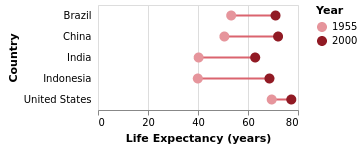

In [35]:
layerRangedDot =
    let label = description "A ranged dot plot that uses 'layer' to convey changing life expectancy for the five most populous countries (between 1955 and 2000)."
        dvals = dataFromUrl "data/countries.json" []
    
        trans = transform
                  . filter (FOneOf "country" (Strings ["China", "India", "United States", "Indonesia", "Brazil"]))
                  . filter (FOneOf "year" (Numbers [1955, 2000]))
        enc = encoding
                 . position X [ PName "life_expect", PmType Quantitative
                              , PAxis [AxTitle "Life Expectancy (years)"]
                              ]
                 . position Y [ PName "country", PmType Nominal
                              , PAxis [ AxTitle "Country"
                                      , AxOffset 5
                                      , AxTicks False
                                      , AxMinExtent 70
                                      , AxDomain False
                                      ]
                              ]
        
        lyr1 = [mark Line [], encoding (detail [DName "country", DmType Nominal] (color [MString "#db646f"] []))]

        sc2 = domainRangeMap (1955, "#e6959c") (2000, "#911a24")
        enc2 = encoding
                 . color [MName "year", MmType Ordinal, MScale sc2, MLegend [LTitle "Year"]]
                 . size [MNumber 100]
                 . opacity [MNumber 1]
        lyr2 = [mark Point [MFilled True], enc2 []]
        lyr = layer (map asSpec [lyr1, lyr2])
        
    in toVegaLite [label, dvals, trans [], enc [], lyr]

vlShow layerRangedDot

In [36]:
validate layerRangedDotSpec layerRangedDot

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Bullet Chart

From https://vega.github.io/vega-lite/examples/facet_bullet.html

In [37]:
facetBulletSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "data": {
    "values": [
      {"title":"Revenue", "subtitle":"US$, in thousands", "ranges":[150,225,300],"measures":[220,270],"markers":[250]},
      {"title":"Profit", "subtitle":"%", "ranges":[20,25,30],"measures":[21,23],"markers":[26]},
      {"title":"Order Size", "subtitle":"US$, average", "ranges":[350,500,600],"measures":[100,320],"markers":[550]},
      {"title":"New Customers", "subtitle":"count", "ranges":[1400,2000,2500],"measures":[1000,1650],"markers":[2100]},
      {"title":"Satisfaction", "subtitle":"out of 5", "ranges":[3.5,4.25,5],"measures":[3.2,4.7],"markers":[4.4]}
    ]
  },
  "facet": {
    "row": {
      "field": "title", "type": "ordinal",
      "header": {"labelAngle": 0, "title": ""}
    }
  },
  "spacing": 10,
  "spec": {
    "layer": [{
      "mark": {"type": "bar", "color": "#eee"},
      "encoding": {
        "x": {
          "field": "ranges[2]", "type": "quantitative", "scale": {"nice": false},
          "title": null
        }
      }
    },{
      "mark": {"type": "bar", "color": "#ddd"},
      "encoding": {
        "x": {"field": "ranges[1]", "type": "quantitative"}
      }
    },{
      "mark": {"type": "bar", "color": "#ccc"},
      "encoding": {
        "x": {"field": "ranges[0]", "type": "quantitative"}
      }
    },{
      "mark": {"type": "bar", "color": "lightsteelblue", "size": 10},
      "encoding": {
        "x": {"field": "measures[1]", "type": "quantitative"}
      }
    },{
      "mark": {"type": "bar", "color": "steelblue", "size": 10},
      "encoding": {
        "x": {"field": "measures[0]", "type": "quantitative"}
      }
    },{
      "mark": {"type": "tick", "color": "black"},
      "encoding": {
        "x": {"field": "markers[0]", "type": "quantitative"}
      }
    }]
  },
  "resolve": {
    "scale": {
      "x": "independent"
    }
  },
  "config": {
    "tick": {"thickness": 2}
  }
}
|]

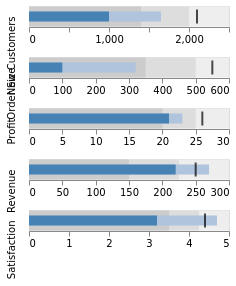

In [38]:
facetBullet =
    let rows = map mkRow [ ("Revenue", "US$, in thousands", [150, 225, 300], [220, 270], [250])
                         , ("Profit", "%", [20, 25, 30], [21, 23], [26])
                         , ("Order Size", "US$, average", [350, 500, 600], [100, 320], [550])
                         , ("New Customers", "count", [1400, 2000, 2500], [1000, 1650], [2100])
                         , ("Satisfaction", "out of 5", [3.5, 4.25, 5], [3.2, 4.7], [4.4])
                         ]

        -- mkRow :: (T.Text, T.Text, [Double], [Double], [Double]) -> A.Value
        mkRow (ttl, stl, rngs, ms, mks) = A.object [ "title" .= ttl
                                                   , "subtitle" .= stl
                                                   , "ranges" .= rngs
                                                   , "measures" .= ms
                                                   , "markers" .= mks
                                                   ]
                                                   
        dvals = dataFromJson (A.toJSON rows) []

        fct = facet [RowBy [FName "title", FmType Ordinal, FHeader [HLabelAngle 0, HTitle ""]]]

        encX name opts = encoding (position X ([PName name, PmType Quantitative] ++ opts) [])

        lyr1 = [mark Bar [MColor "#eee"], encX "ranges[2]" [PScale [SNice (IsNice False)], PNoTitle]]
        lyr2 = [mark Bar [MColor "#ddd"], encX "ranges[1]" []]
        lyr3 = [mark Bar [MColor "#ccc"], encX "ranges[0]" []]
        lyr4 = [mark Bar [MColor "lightsteelblue", MSize 10], encX "measures[1]" []]
        lyr5 = [mark Bar [MColor "steelblue", MSize 10], encX "measures[0]" []]
        lyr6 = [mark Tick [MColor "black"], encX "markers[0]" []]

        lyr = layer (map asSpec [lyr1, lyr2, lyr3, lyr4, lyr5, lyr6])
        spec = specification (asSpec [lyr])

        rslv = resolve (resolution (RScale [(ChX, Independent)]) [])
        cnf = configure (configuration (TickStyle [MThickness 2]) [])

    in toVegaLite [dvals, fct, spacing 10, spec, rslv, cnf]

vlShow facetBullet

In [39]:
validate facetBulletSpec facetBullet

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Layered Plot with Dual-Axis

From https://vega.github.io/vega-lite/examples/layer_dual_axis.html

Note that Vega-Lite supports both `average` and `mean` (as synonyms) but `hvega` only provides `Mean`, so there will be differences in the JSON comparison below.

In [40]:
layerDualAxisSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "description": "A dual axis chart, created by setting y's scale resolution to `\"independent\"`",
  "width": 400, "height": 300,
  "data": {
    "url": "data/weather.csv"
  },
  "transform": [{"filter": "datum.location == \"Seattle\""}],
  "encoding": {
    "x": {
        "field": "date",
        "axis": {"format": "%b", "title": null},
        "type": "temporal",
        "timeUnit": "month"
    }
  },
  "layer": [
    {
      "mark": {"opacity": 0.3, "type": "area", "color": "#85C5A6"},
      "encoding": {
        "y": {
          "aggregate": "average",
          "field": "temp_max",
          "scale": {"domain": [0, 30]},
          "type": "quantitative",
          "axis": {"title": "Avg. Temperature (°C)", "titleColor": "#85C5A6"}
        },

        "y2": {
          "aggregate": "average",
          "field": "temp_min"
        }
      }
    },
    {
      "mark": {"stroke": "#85A9C5", "type": "line", "interpolate": "monotone"},
      "encoding": {
        "y": {
          "aggregate": "average",
          "field": "precipitation",
          "type": "quantitative",
          "axis": {"title": "Precipitation (inches)", "titleColor":"#85A9C5"}
        }
      }
    }
  ],
  "resolve": {"scale": {"y": "independent"}}
}
|]

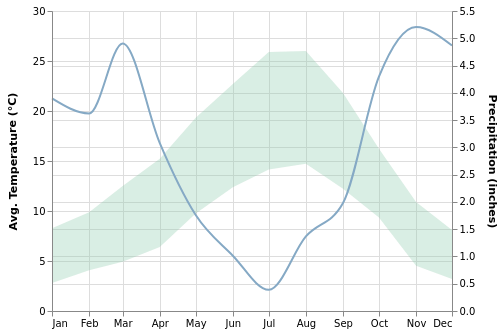

In [41]:
layerDualAxis =
    let label = description "A dual axis chart, created by setting y's scale resolution to `\"independent\"`"
        dvals = dataFromUrl "data/weather.csv" []
        
        trans = transform (filter (FExpr "datum.location == \"Seattle\"") [])
        enc = encoding (position X [ PName "date", PmType Temporal, PTimeUnit Month
                                   , PAxis [AxFormat "%b", AxNoTitle]
                                   ]
                                   [])

        col1 = "#85C5A6"
        col2 = "#85A9C5"
        enc1 = encoding
                 . position Y [ PName "temp_max", PmType Quantitative, PAggregate Mean
                              , PScale [SDomain (DNumbers [0, 30])]
                              , PAxis [AxTitle "Avg. Temperature (°C)", AxTitleColor col1]
                              ]
                 . position Y2 [PName "temp_min", PAggregate Mean]
        enc2 = encoding
                 . position Y [ PName "precipitation", PmType Quantitative, PAggregate Mean
                              , PAxis [AxTitle "Precipitation (inches)", AxTitleColor col2]
                              ]
        lyr1 = [mark Area [MOpacity 0.3, MColor col1], enc1 []]
        lyr2 = [mark Line [MStroke col2, MInterpolate Monotone], enc2 []]
        
        lyr = layer (map asSpec [lyr1, lyr2])
        rsv = resolve (resolution (RScale [(ChY, Independent)]) [])
        
    in toVegaLite [label, height 300, width 400, dvals, trans, enc, lyr, rsv]
    
vlShow layerDualAxis

In [42]:
validate layerDualAxisSpec layerDualAxis

The visualization and expected specification do not match.

Values are different for "layer"
  Expected: Array [Object (fromList [("mark",Object (fromList [("color",String "#85C5A6"),("opacity",Number 0.3),("type",String "area")])),("encoding",Object (fromList [("y2",Object (fromList [("field",String "temp_min"),("aggregate",String "average")])),("y",Object (fromList [("field",String "temp_max"),("scale",Object (fromList [("domain",Array [Number 0.0,Number 30.0])])),("aggregate",String "average"),("type",String "quantitative"),("axis",Object (fromList [("titleColor",String "#85C5A6"),("title",String "Avg. Temperature (\176C)")]))]))]))]),Object (fromList [("mark",Object (fromList [("stroke",String "#85A9C5"),("interpolate",String "monotone"),("type",String "line")])),("encoding",Object (fromList [("y",Object (fromList [("field",String "precipitation"),("aggregate",String "average"),("type",String "quantitative"),("axis",Object (fromList [("titleColor",String "#85A9C5"),("title",String 

Return to the [Table of Contents](#Table-of-Contents).

### Weekly Weather Plot

From https://vega.github.io/vega-lite/examples/bar_layered_weather.html

In [43]:
barLayeredWeatherSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "description": "A layered bar chart with floating bars representing weekly weather data",
  "title": {
    "text": ["Weekly Weather", "Observations and Predictions"],
    "frame": "group"
  },
  "data": {
    "url": "data/weather.json"
  },
  "width": 250,
  "height": 200,
  "encoding": {
    "x": {
      "field": "id",
      "type": "ordinal",
      "axis": {
        "domain": false,
        "ticks": false,
        "labels": false,
        "title": null,
        "titlePadding": 25,
        "orient": "top"
      }
    }
  },
  "layer": [
    {
      "mark": {
        "type": "bar",
        "style": "box"
      },
      "encoding": {
        "y": {
          "field": "record.low",
          "type": "quantitative",
          "scale": {"domain": [10, 70]},
          "axis": {"title": "Temperature (F)"}
        },
        "y2": {"field": "record.high"},
        "size": {"value": 20},
        "color": {"value": "#ccc"}
      }
    },
    {
      "mark": {
        "type": "bar",
        "style": "box"
      },
      "encoding": {
        "y": {
          "field": "normal.low",
          "type": "quantitative"
        },
        "y2": {"field": "normal.high"},
        "size": {"value": 20},
        "color": {"value": "#999"}
      }
    },
    {
      "mark": {"type": "bar", "style": "box"},
      "encoding": {
        "y": {
          "field": "actual.low",
          "type": "quantitative"
        },
        "y2": {"field": "actual.high"},
        "size": {"value": 12},
        "color": {"value": "#000"}
      }
    },
    {
      "mark": {"type": "bar", "style": "box"},
      "encoding": {
        "y": {
          "field": "forecast.low.low",
          "type": "quantitative"
        },
        "y2": {"field": "forecast.low.high"},
        "size": {"value": 12},
        "color": {"value": "#000"}
      }
    },
    {
      "mark": {"type": "bar", "style": "box"},
      "encoding": {
        "y": {
          "field": "forecast.low.high",
          "type": "quantitative"
        },
        "y2": {"field": "forecast.high.low"},
        "size": {"value": 3},
        "color": {"value": "#000"}
      }
    },
    {
      "mark": {"type": "bar", "style": "box"},
      "encoding": {
        "y": {
          "field": "forecast.high.low",
          "type": "quantitative"
        },
        "y2": {"field": "forecast.high.high"},
        "size": {"value": 12},
        "color": {"value": "#000"}
      }
    },
    {
      "mark": {"type": "text", "align": "center", "baseline": "bottom", "y": -5},
      "encoding": {
        "text": {
          "field": "day",
          "type": "nominal"
        }
      }
    }
  ]
}
|]

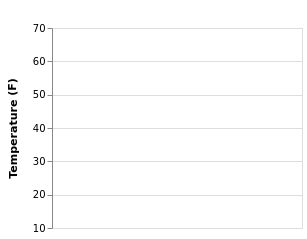

In [44]:
barLayeredWeather =
    let label = description "A layered bar chart with floating bars representing weekly weather data"
        dvals = dataFromUrl "data/weather.json" []
        
        -- hvega splits titles and sub-titles on \n to create multi-line
        -- labels.
        titleOpts = title "Weekly Weather\nObservations and Predictions" [TFrame FrGroup]

        axis1 = [AxDomain False, AxTicks False, AxLabels False, AxNoTitle, AxTitlePadding 25, AxOrient STop]
        enc = encoding (position X [PName "id", PmType Ordinal, PAxis axis1] [])
       
        enc1 = encoding
                 . position Y [ PName "record.low", PmType Quantitative
                              , PScale [SDomain (DNumbers [10, 70])]
                              , PAxis [AxTitle "Temperature (F)"]
                              ]
                 . position Y2 [PName "record.high"]
                 . size [MNumber 20]
                 . color [MString "#ccc"]
        lyr1 = [mark Bar [MStyle ["box"]], enc1 []]

        enc2 = encoding
                 . position Y [PName "normal.low", PmType Quantitative]
                 . position Y2 [PName "normal.high"]
                 . size [MNumber 20]
                 . color [MString "#999"]                
        lyr2 = [mark Bar [MStyle ["box"]], enc2 []]
        
        enc3 = encoding
                 . position Y [PName "actual.low", PmType Quantitative]
                 . position Y2 [PName "actual.high"]
                 . size [MNumber 12]
                 . color [MString "#000"]                
        lyr3 = [mark Bar [MStyle ["box"]], enc3 []]
        
        enc4 = encoding
                 . position Y [PName "forecast.low.low", PmType Quantitative]
                 . position Y2 [PName "forecast.low.high"]
                 . size [MNumber 12]
                 . color [MString "#000"]                
        lyr4 = [mark Bar [MStyle ["box"]], enc4 []]
        
        enc5 = encoding
                 . position Y [PName "forecast.low.high", PmType Quantitative]
                 . position Y2 [PName "forecast.high.low"]
                 . size [MNumber 3]
                 . color [MString "#000"]                
        lyr5 = [mark Bar [MStyle ["box"]], enc5 []]

        enc6 = encoding
                 . position Y [PName "forecast.high.low", PmType Quantitative]
                 . position Y2 [PName "forecast.high.high"]
                 . size [MNumber 12]
                 . color [MString "#000"]                
        lyr6 = [mark Bar [MStyle ["box"]], enc6 []]

        enc7 = encoding (text [TName "day", TmType Nominal] [])
        lyr7 = [mark Text [MAlign AlignCenter, MBaseline AlignBottom, MY (-5)], enc7]

        lyr = layer (map asSpec [lyr1, lyr2, lyr3, lyr4, lyr5, lyr6, lyr7])
        
    in toVegaLite [label, titleOpts, dvals, width 250, height 200, enc, lyr]
    
vlShow barLayeredWeather

In [45]:
validate barLayeredWeatherSpec barLayeredWeather

Okay

Return to the [Table of Contents](#Table-of-Contents).

### Wheat and Wages Example

From https://vega.github.io/vega-lite/examples/wheat_wages.html

In [46]:
wheatWagesSpec = [aesonQQ|
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 900,
  "height": 400,
  "data": { "url": "data/wheat.json"},
  "transform": [{"calculate": "+datum.year + 5", "as": "year_end"}],
  "layer": [
    {
      "mark": {
        "type": "bar",
        "fill": "#aaa",
        "stroke": "#999"
      },
      "encoding": {
        "x": {
          "field": "year",
          "type": "quantitative",
          "axis": {
            "tickCount": 5,
            "format": "d"
          }
        },
        "x2": {
          "field": "year_end"
        },
        "y": {
          "field": "wheat",
          "type": "quantitative",
          "axis": { "zindex": 1 }
        }
      }
    },
    {
      "data": {
        "values": [
          { "year": "1600" },
          { "year": "1650" },
          { "year": "1700" },
          { "year": "1750" },
          { "year": "1800" }
        ]
      },
      "mark": {
        "type": "rule",
        "stroke": "#000",
        "strokeWidth": 0.6,
        "opacity": 0.5
      },
      "encoding": {
        "x": {
          "field": "year",
          "type": "quantitative"
        }
      }
    },
    {
      "mark": {
        "type": "area",
        "color": "#a4cedb",
        "opacity": 0.7
      },
      "encoding": {
        "x": {
          "field": "year",
          "type": "quantitative"
        },
        "y": {
          "field": "wages",
          "type": "quantitative"
        }
      }
    },
    {
      "mark": {
        "type": "line",
        "color": "#000",
        "opacity": 0.7
      },
      "encoding": {
        "x": {
          "field": "year",
          "type": "quantitative"
        },
        "y": {
          "field": "wages",
          "type": "quantitative"
        }
      }
    },
    {
      "mark": {
        "type": "line",
        "yOffset": -2,
        "color": "#EE8182"
      },
      "encoding": {
        "x": {
          "field": "year",
          "type": "quantitative"
        },
        "y": {
          "field": "wages",
          "type": "quantitative"
        }
      }
    },
    {
      "data": {"url": "data/monarchs.json"},
      "transform": [
        { "calculate": "((!datum.commonwealth && datum.index % 2) ? -1: 1) * 2 + 95", "as": "offset" },
        { "calculate": "95", "as": "y" }
      ],
      "mark": {
        "type": "bar",
        "stroke": "#000"
      },
      "encoding": {
        "x": {
          "field": "start",
          "type": "quantitative"
        },
        "x2": {
          "field": "end"
        },
        "y": {
          "field": "y",
          "type": "quantitative"
        },
        "y2": { "field": "offset" },
        "fill": {
          "field": "commonwealth",
          "scale": { "range": ["black", "white"] },
          "legend": null,
          "type": "nominal"
        }
      }
    },
    {
      "data": {
        "url": "data/monarchs.json"
      },
      "transform": [
        { "calculate": "((!datum.commonwealth && datum.index % 2) ? -1: 1) + 95", "as": "off2" },
        { "calculate": "+datum.start + (+datum.end - +datum.start)/2", "as": "x"}
      ],
      "mark": {
        "type": "text",
        "yOffset": 16,
        "fontSize": 9,
        "baseline": "bottom",
        "fontStyle": "italic"
      },
      "encoding": {
        "x": {
          "field": "x",
          "type": "quantitative"
        },
        "y": {"field": "off2", "type": "quantitative"},
        "text": {"field": "name", "type": "nominal"}
      }
    }
  ],
  "config": {
    "axis": {
      "title": null,
      "gridColor": "white",
      "gridOpacity": 0.25,
      "domain": false
    },
    "view": { "stroke": "transparent" }
  }
}
|]

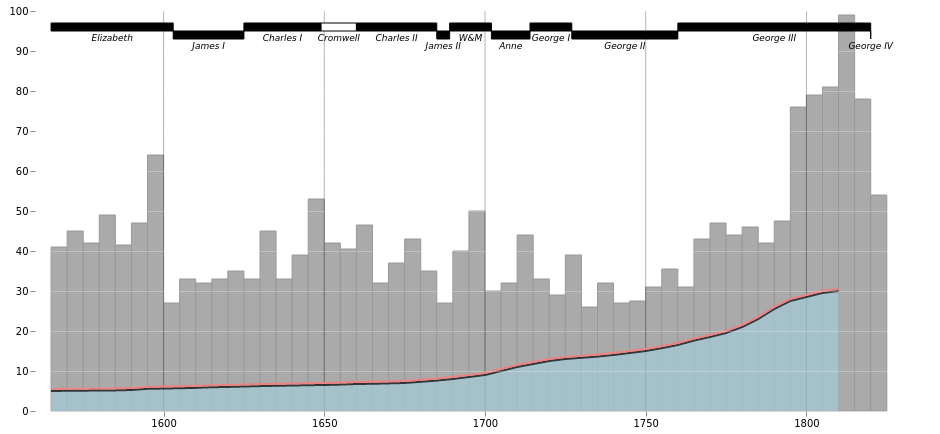

In [47]:
wheatWages =
    let dvals = dataFromUrl "data/wheat.json" []
        trans = transform (calculateAs "+datum.year + 5" "year_end" [])

        posX extra = position X ([PName "year", PmType Quantitative] ++ extra)
        enc1 = encoding
                 . posX [PAxis [AxTickCount 5, AxFormat "d"]]
                 . position X2 [PName "year_end"]
                 . position Y [PName "wheat", PmType Quantitative, PAxis [AxZIndex 1]]
        lyr1 = [mark Bar [MFill "#aaa", MStroke "#999"], enc1 []]
 
        dvals2 = dataFromColumns []
                   . dataColumn "year" (Strings ["1600", "1650", "1700", "1750", "1800"])
        enc2 = encoding
                 . posX []
        lyr2 = [dvals2 [], mark Rule [MStroke "#000", MStrokeWidth 0.6, MOpacity 0.5], enc2 []]

        enc3 = encoding
                 . posX []
                 . position Y [PName "wages", PmType Quantitative] 
        lyr3 = [mark Area [MColor "#a4cedb", MOpacity 0.7], enc3 []]
        lyr4 = [mark Line [MColor "#000", MOpacity 0.7], enc3 []]
        
        lyr5 = [mark Line [MColor "#EE8182", MYOffset (-2)], enc3 []]
        
        dvals6 = dataFromUrl "data/monarchs.json" []
        trans6 = transform
                   . calculateAs "((!datum.commonwealth && datum.index % 2) ? -1: 1) * 2 + 95" "offset"
                   . calculateAs "95" "y"
        enc6 = encoding
                  . position X [PName "start", PmType Quantitative]
                  . position X2 [PName "end"]
                  . position Y [PName "y", PmType Quantitative]
                  . position Y2 [PName "offset"]
                  . fill [MName "commonwealth", MmType Nominal, MScale [SRange (RStrings ["black", "white"])], MLegend []]
        lyr6 = [dvals6, trans6 [], mark Bar [MStroke "#000"], enc6 []]
        
        trans7 = transform
                   . calculateAs "((!datum.commonwealth && datum.index % 2) ? -1: 1) + 95" "off2"
                   . calculateAs "+datum.start + (+datum.end - +datum.start)/2" "x"
        enc7 = encoding
                  . position X [PName "x", PmType Quantitative]
                  . position Y [PName "off2", PmType Quantitative]
                  . text [TName "name", TmType Nominal]
        markOpts7 = mark Text [MYOffset 16, MFontSize 9, MBaseline AlignBottom, MFontStyle "italic"]
        lyr7 = [dvals6, trans7 [], markOpts7, enc7 []]

        lyr = layer (map asSpec [lyr1, lyr2, lyr3, lyr4, lyr5, lyr6, lyr7])

        cnf = configure
                . configuration (Axis [NoTitle, GridColor "white", GridOpacity 0.25, Domain False])
                . configuration (ViewStyle [ViewStroke "transparent"])
                
    in toVegaLite [dvals, height 400, width 900, trans, lyr, cnf []]

vlShow wheatWages

In [48]:
validate wheatWagesSpec wheatWages

Okay

Return to the [Table of Contents](#Table-of-Contents).